# **Modelling**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [5]:
df = pd.read_csv("Datasets/concatenated/labeled_islam_tweetdata.csv")
df.rename(columns={'clean_text': 'texts'}, inplace=True)
df.head(5)

,texts,created_at,location,category
0,hostility warranted context putin referred wes...,2022-10-03,Noemaville,Positive
1,reference hate never seems include view islam ...,2022-10-03,NaN,Negative
2,love edits goku hes muslim,2022-10-03,NaN,Positive
3,1400yearold secret pakistan pakistan made alla...,2022-10-03,NaN,Negative
4,facts narrative islam fought top 5 guy argumen...,2022-10-03,"Bronx, NY",Positive


<AxesSubplot: xlabel='category'>

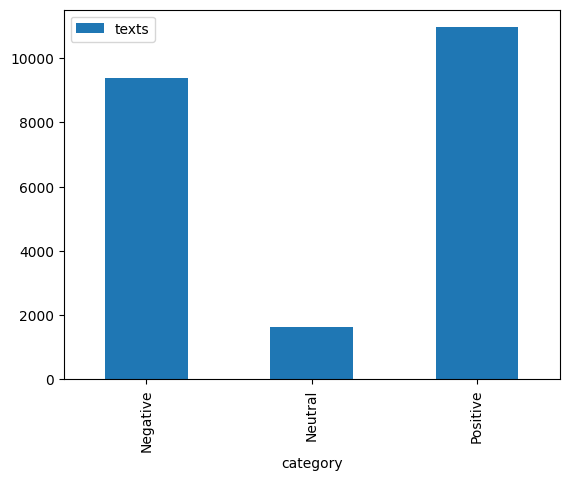

In [12]:
df[['texts', 'category']].groupby('category').count().plot(kind='bar')

<AxesSubplot: >

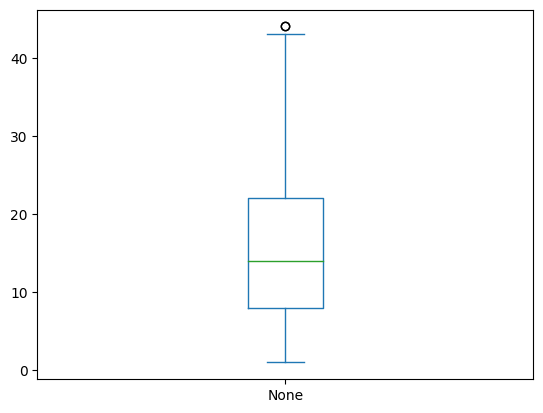

In [13]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['texts']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

In [14]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

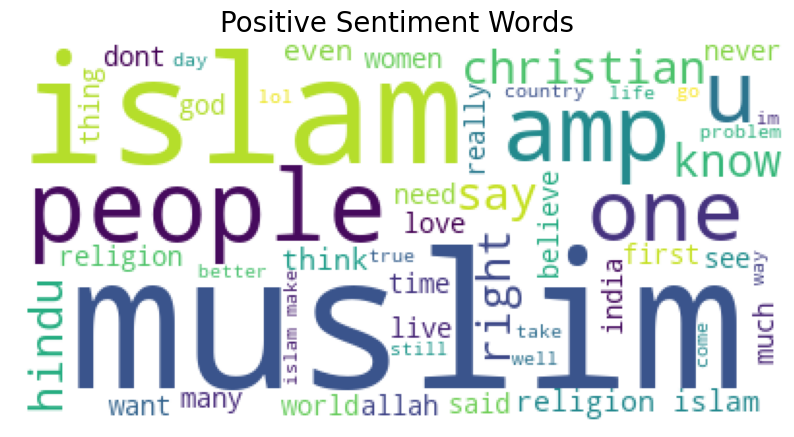

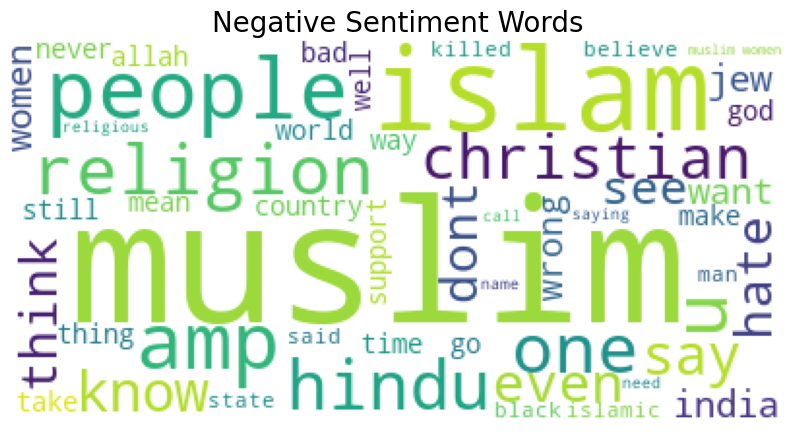

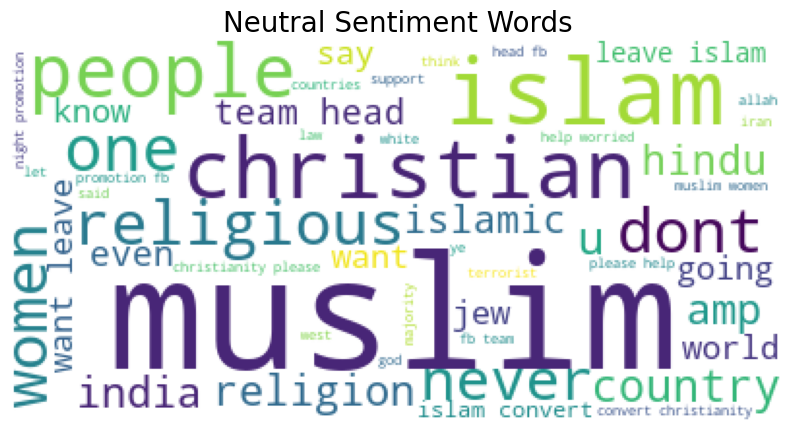

In [15]:
from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['texts']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(df, 'Positive')
     
# Negative tweet words
wordcount_gen(df, 'Negative')
     
# Neutral tweet words
wordcount_gen(df, 'Neutral')

Data preprocessing

In [16]:
# One hot encoding
category = pd.get_dummies(df.category)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='category')
df_baru

,texts,created_at,location,Negative,Neutral,Positive
0,hostility warranted context putin referred wes...,2022-10-03,Noemaville,0,0,1
1,reference hate never seems include view islam ...,2022-10-03,NaN,1,0,0
2,love edits goku hes muslim,2022-10-03,NaN,0,0,1
3,1400yearold secret pakistan pakistan made alla...,2022-10-03,NaN,1,0,0
4,facts narrative islam fought top 5 guy argumen...,2022-10-03,"Bronx, NY",0,0,1
...,...,...,...,...,...,...
21974,apartheid israel kills palestinian children go...,2022-10-13,NaN,1,0,0
21975,perry anderson indian ideology hand afspa fall...,2022-10-13,NaN,0,0,1
21976,fangirl islam last person fan sport weirdo thi...,2022-10-13,NaN,1,0,0
21977,ki kesay hoti haiclickhttpstco6l6bqlidu9at 300...,2022-10-13,NaN,1,0,0


In [17]:
# Membagi attribut dengan label
sentence = df_baru['texts'].values
label = df_baru[['Negative', 'Neutral', 'Positive']].values

In [18]:
# Membagi data latih dan data testing
from sklearn.model_selection import train_test_split
sentence_latih, sentence_test, label_latih, label_test = train_test_split(sentence, label, test_size=0.2)

In [19]:
# Mengimplementasikan tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=8000, oov_token='<OOV>')
tokenizer.fit_on_texts(sentence_latih)
tokenizer.fit_on_texts(sentence_test)

sekuens_latih = tokenizer.texts_to_sequences(sentence_latih)
sekuens_test = tokenizer.texts_to_sequences(sentence_test)

padded_latih = pad_sequences(sekuens_latih)
padded_test = pad_sequences(sekuens_test)

Modelling ML

In [20]:
# Membuat model dan mengcompile model
import tensorflow as tf
model = tf.keras.Sequential([
  # Menerapkan embedding
  tf.keras.layers.Embedding(input_dim=8000, output_dim=64),
  # Menerapkan LSTM
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(32, activation='swish'),
  tf.keras.layers.Dense(16, activation='swish'),
  tf.keras.layers.Dense(3, activation='softmax')
])
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [13]:
# Mengimplementasikan Callback untuk accuracy diatas 91%
# class Callback_80(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if logs.get('accuracy')>0.8 and logs.get('val_accuracy')>0.74:
#       print("\nAkurasi telah mencapai >80%!")
#       self.model.stop_training = True
# callbacks = Callback_80()

In [21]:
# Menjalankan model
num_epochs = 10
history = model.fit(padded_latih, label_latih, epochs=num_epochs, steps_per_epoch=32,
                    validation_data=(padded_test, label_test), verbose=1#, callbacks=[callbacks]
                    )

Epoch 1/10
32/32 [==============================] - 11s 207ms/step - loss: 0.8083 - accuracy: 0.6126 - val_loss: 0.6445 - val_accuracy: 0.7416
Epoch 2/10
32/32 [==============================] - 5s 154ms/step - loss: 0.4268 - accuracy: 0.8336 - val_loss: 0.5139 - val_accuracy: 0.7957
Epoch 3/10
32/32 [==============================] - 5s 153ms/step - loss: 0.2241 - accuracy: 0.9183 - val_loss: 0.5838 - val_accuracy: 0.8030
Epoch 4/10
32/32 [==============================] - 5s 150ms/step - loss: 0.1277 - accuracy: 0.9544 - val_loss: 0.7412 - val_accuracy: 0.8094
Epoch 5/10
32/32 [==============================] - 4s 141ms/step - loss: 0.0838 - accuracy: 0.9711 - val_loss: 0.8427 - val_accuracy: 0.8091
Epoch 6/10
32/32 [==============================] - 5s 168ms/step - loss: 0.0622 - accuracy: 0.9795 - val_loss: 0.9629 - val_accuracy: 0.7989
Epoch 7/10
32/32 [==============================] - 7s 221ms/step - loss: 0.0507 - accuracy: 0.9842 - val_loss: 1.1036 - val_accuracy: 0.8051
Epoch

<function matplotlib.pyplot.show(close=None, block=None)>

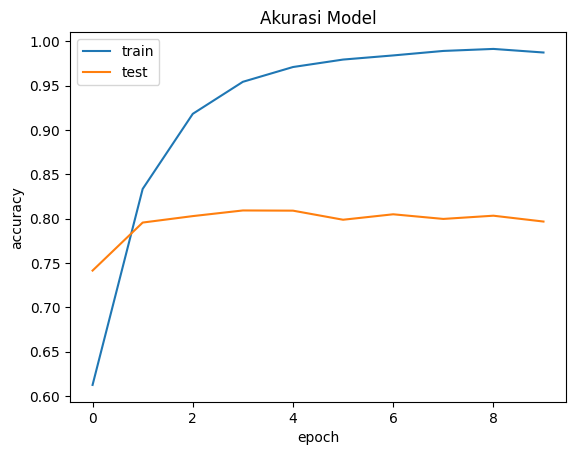

In [22]:
# Membuat plot dari accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

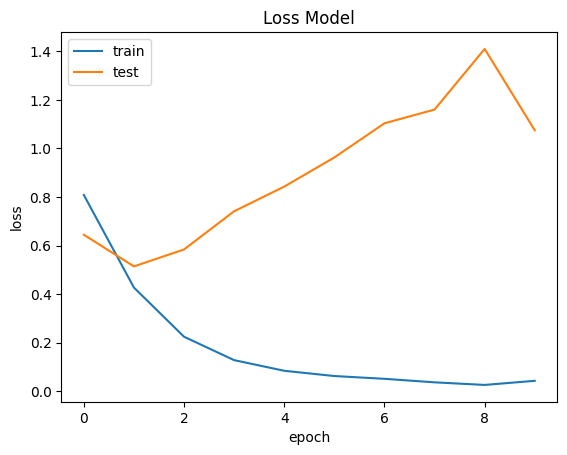

In [23]:
# Membuat plot dari loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show

138/138 [==============================] - 2s 7ms/step


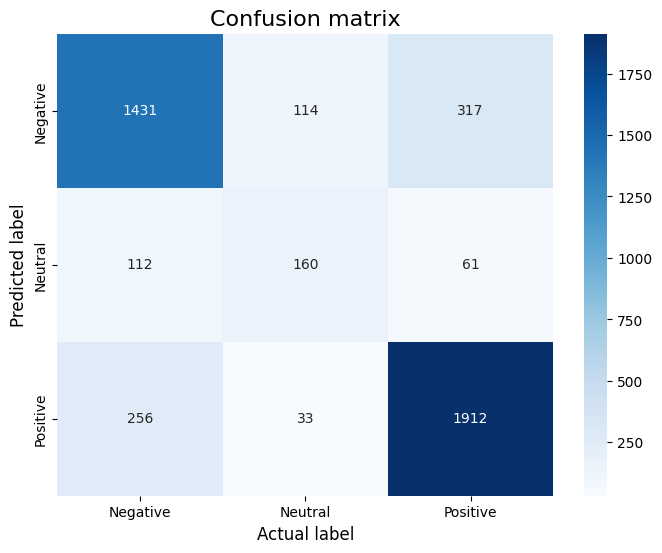

In [24]:
# Membuat confussion matrix
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, padded_test, label_test)

In [18]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


Predicting the data

In [28]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt)
    # xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    return sentiment_classes[yt[0]]

In [43]:
df_tweet = pd.read_csv("Datasets/concatenated/clean_full_tweetdata.csv")
df_tweet.head(5)

,texts,created_at,location
0,hostility warranted context putin referred wes...,2022-10-03,Noemaville
1,reference hate never seems include view islam ...,2022-10-03,NaN
2,love edits goku hes muslim,2022-10-03,NaN
3,1400yearold secret pakistan pakistan made alla...,2022-10-03,NaN
4,facts narrative islam fought top 5 guy argumen...,2022-10-03,"Bronx, NY"


In [60]:
df_tweet.dropna(subset=['texts'], axis=0, inplace=True)
len(df_tweet)

21979

In [61]:
df_tweet['category'] = [predict_class([x]) for x in df_tweet['texts']]

1/1 [==============================] - 0s 139ms/step


In [62]:
df_tweet.head(5)

,texts,created_at,location,category
0,hostility warranted context putin referred wes...,2022-10-03,Noemaville,Positive
1,reference hate never seems include view islam ...,2022-10-03,NaN,Negative
2,love edits goku hes muslim,2022-10-03,NaN,Positive
3,1400yearold secret pakistan pakistan made alla...,2022-10-03,NaN,Negative
4,facts narrative islam fought top 5 guy argumen...,2022-10-03,"Bronx, NY",Positive


In [63]:
df_tweet.to_csv('Datasets/concatenated/labeled_islam_tweetdata.csv', index = False)

In [64]:
text = 'He is a best minister india ever had seen'
x = predict_class([text])
print("x is " + x)

1/1 [==============================] - 0s 22ms/step
x is Positive
